Things to do:
 - find better way to calculate ratio for beehives
 - better way to measure increase and decrease, maybe with mean trend (?)

In [1]:
#%matplotlib inline
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#For interactive plots
import ipywidgets as widgets
from scipy import stats
from ipywidgets import interact, interact_manual

Load datasets

In [2]:
beehives = pd.read_csv('data/beehives.csv',  encoding='utf-8')
forest_land = pd.read_csv('data/forest_land.csv',  encoding='utf-8')
agricultural_land = pd.read_csv('data/agricultural_land.csv',  encoding='utf-8')
country_land = pd.read_csv('data/country_land.csv',  encoding='utf-8')

Define global variables

In [3]:
continents = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
continents_areas = ['Western Africa','Western Asia','Western Europe','Middle Africa','Central America','Central Asia',
                    'South America', 'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'South-Eastern Asia', 'Southern Africa',
                    'Southern Asia', 'Southern Europe', 'Northern Africa', 'Northern America', 'Northern Europe']
areas_to_remove = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania','Western Africa','Western Asia','Western Europe',
         'World','Middle Africa','Central America','Central Asia','Small Island Developing States', 
         'Pacific Islands Trust Territory','South America', 'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 
         'Land Locked Developing Countries', 'Least Developed Countries','South-Eastern Asia', 'Southern Africa', 
         'Southern Asia', 'Southern Europe','Low Income Food Deficit Countries','Northern Africa', 
         'Northern America', 'Northern Europe', 'European Union', 'Net Food Importing Developing Countries', 'Other non-specified areas']


Dropping notation info in the tail of each dataset

In [4]:
forest_land.drop(forest_land.tail(5).index, inplace = True)
agricultural_land.drop(agricultural_land.tail(8).index, inplace = True)
beehives.drop(beehives.tail(5).index, inplace = True)
country_land.drop(country_land.tail(6).index, inplace = True)

First look at the data

In [5]:
forest_land.head(5)

,Country or Area,Element,Year,Unit,Value,Value Footnotes
0,Afghanistan,Area,2017.0,1000 ha,1350.0,Fm
1,Afghanistan,Area,2016.0,1000 ha,1350.0,Fm
2,Afghanistan,Area,2015.0,1000 ha,1350.0,E
3,Afghanistan,Area,2014.0,1000 ha,1350.0,Fm
4,Afghanistan,Area,2013.0,1000 ha,1350.0,Fm


Find countries that are not present in all datasets

In [6]:
# keeping only countries that datasets have in common
countries_agr = set(agricultural_land["Country or Area"].unique())
countries_for = set(forest_land["Country or Area"].unique())
countries_bee = set(beehives["Country or Area"].unique())
countries_cou = set(country_land["Country or Area"].unique())

countries = sorted(countries_agr & countries_for & countries_bee & countries_cou) # - set(areas_to_remove))

# keeping only years that datasets have in common
years_agr = set(agricultural_land["Year"].unique())
years_for = set(forest_land["Year"].unique())
years_bee = set(beehives["Year"].unique())
years_cou = set(country_land["Year"].unique())

years = sorted(years_agr & years_for & years_bee & years_cou)

Drop non necessary data such as years and countries not present in all dataframes


In [7]:
# drop countries 
forest_land.drop(forest_land[~forest_land["Country or Area"].isin(countries)].index, inplace = True)
agricultural_land.drop(agricultural_land[~agricultural_land["Country or Area"].isin(countries)].index, inplace = True)
beehives.drop(beehives[~beehives["Country or Area"].isin(countries)].index, inplace = True)
country_land.drop(country_land[~country_land["Country or Area"].isin(countries)].index, inplace = True)

# drop years 
forest_land.drop(forest_land[~forest_land["Year"].isin(years)].index, inplace = True)
agricultural_land.drop(agricultural_land[~agricultural_land["Year"].isin(years)].index, inplace = True)
beehives.drop(beehives[~beehives["Year"].isin(years)].index, inplace = True)
country_land.drop(country_land[~country_land["Year"].isin(years)].index, inplace = True)

# drop data of 'Carbon stock in living biomass' in the forest dataset
forest_land.drop(forest_land[forest_land["Element"] == "Carbon stock in living biomass"].index, inplace = True)

Calculating ratio for forest land, agricultural land and beehives. These quantities are defined as:

$$ Ratio_{forest} = \frac{ForestArea}{TotalArea} $$

$$ Ratio_{agriculture} = \frac{AgriculturalArea}{TotalArea} $$

$$ Ratio_{beehives} = \frac{BeehivesNumber}{TotalArea} $$

In [8]:
for country in countries:
    #print("country: ", country)
    for year in years:
        # calculate and insert ratio in corresponding dataframe(for each country and year)
        try:
            country_elem = country_land.loc[(country_land["Country or Area"] == country) & (country_land["Year"] == year), "Value"].values[0]

            forest_elem = forest_land.loc[(forest_land["Country or Area"] == country) & (forest_land["Year"] == year), "Value"].values[0]
            forest_ratio = forest_elem / country_elem
            forest_land.loc[(forest_land["Country or Area"] == country) & (forest_land["Year"] == year),"Ratio"] = forest_ratio
        
            agricultural_elem = agricultural_land.loc[(agricultural_land["Country or Area"] == country) & (agricultural_land["Year"] == year), "Value"].values[0]
            agricultural_ratio = agricultural_elem / country_elem
            agricultural_land.loc[(agricultural_land["Country or Area"] == country) & (agricultural_land["Year"] == year),"Ratio"] = agricultural_ratio
        
            beehives_elem = beehives.loc[(beehives["Country or Area"] == country) & (beehives["Year"] == year), "Value"].values[0]
            beehives_ratio = beehives_elem / country_elem
            beehives.loc[(beehives["Country or Area"] == country) & (beehives["Year"] == year),"Ratio"] = beehives_ratio
        except:
            pass

Visualizing correlation between forest ratio and beehives number, in countries and continents.

In [9]:
@interact
def plot_agricultural_land(area=countries):
    try:
        #agricultural_tmp = agricultural_land[(agricultural_land["Country or Area"] == area) & (agricultural_land["Element"] == "Area")][["Value","Year"]]
        forest_tmp = forest_land[forest_land["Country or Area"] == area][["Ratio","Year"]]
        beehives_tmp = beehives[beehives["Country or Area"] == area][["Value","Year"]]
    
        fig, ax1 = plt.subplots()
        
        color = 'tab:red'
        ax1.set_xlabel('Years')
        ax1.set_ylabel('Beehives number', color=color)
        beehives_tmp.plot(ax=ax1, x="Year", y="Value", color=color, label="Beehives number")
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Forest / Total land ratio', color=color)  # we already handled the x-label with ax1
        forest_tmp.plot(ax=ax2, x="Year", y="Ratio", color=color, label="Forest ratio")
        ax2.tick_params(axis='y', labelcolor=color)
        ax1.get_legend().remove()
        ax2.get_legend().remove()
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
    except:
        pass

interactive(children=(Dropdown(description='area', options=('Africa', 'Albania', 'Algeria', 'Americas', 'Angol…

## Forests analysis

In [10]:
forest_land.loc[(forest_land["Year"] == 2017) & (forest_land["Country or Area"] == "World"), ["Country or Area", "Value", "Ratio"]]

,Country or Area,Value,Ratio
14312,World,3992517.9,0.296048


This means that ~30% of the world land surface area is covered by forests.

Visualizing forests area per continent. 

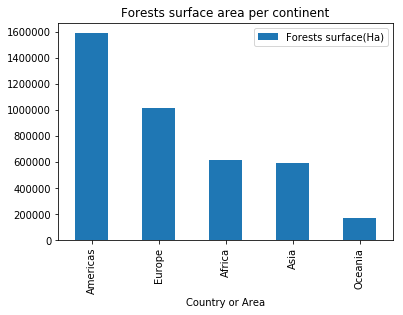

In [11]:
forest_land.sort_values(by=["Value"], ascending=False)\
           .loc[(forest_land["Year"] == 2017) & (forest_land["Country or Area"].isin(continents)), ["Country or Area", "Value"]]\
           .plot.bar(x="Country or Area",y="Value", label="Forests surface(Ha)", title="Forests surface area per continent")

In [12]:
forest_land.sort_values(by=["Ratio"], ascending=False)\
           .loc[(forest_land["Year"] == 2017) & (forest_land["Country or Area"].isin(continents)), ["Country or Area", "Ratio"]]

,Country or Area,Ratio
4334,Europe,0.435598
280,Americas,0.390828
56,Africa,0.203977
9684,Oceania,0.203392
724,Asia,0.185926


### Forests analysis per country

Plotting countries with more forests.

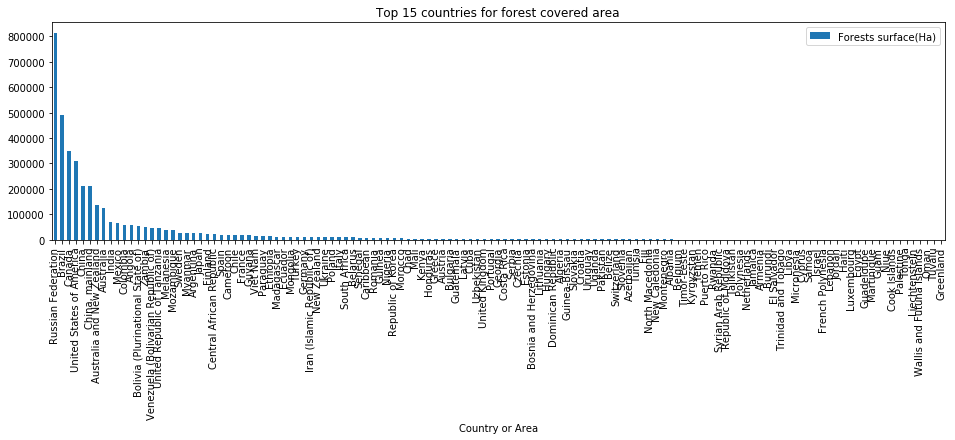

In [13]:
forest_land.sort_values(by=["Value"], ascending=False)\
           .loc[(forest_land["Year"] == 2017) & (~forest_land["Country or Area"].isin(areas_to_remove)), ["Country or Area", "Value"]]\
           .plot.bar(x="Country or Area", y="Value", title="Top 15 countries for forest covered area", label="Forests surface(Ha)", figsize=(16,4))

Plotting the total surface area in each country.

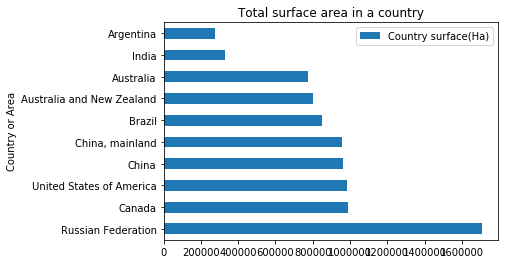

In [14]:
country_land.sort_values(by=["Value"], ascending=False)\
           .loc[(country_land["Year"] == 2017) & (~country_land["Country or Area"].isin(areas_to_remove)), ["Country or Area", "Value"]]\
           .head(10)\
           .plot.barh(x="Country or Area", y="Value", title="Total surface area in a country", label="Country surface(Ha)")

It seems that Russia has almost the double of forests than any other country, but also the double in total area.
We proceed by analysing the ratio between the area covered by forests and the total available surface.

In [15]:
forest_land.sort_values(by=["Ratio"], ascending=False)\
           .loc[(forest_land["Year"] == 2017) & (~forest_land["Country or Area"].isin(areas_to_remove)), ["Country or Area","Ratio"]]\
           .head(10)

,Country or Area,Ratio
5618,Guyana,0.767828
8044,Melanesia,0.703301
9242,Niue,0.688462
6402,Japan,0.660232
4614,Finland,0.656463
14428,Zambia,0.641791
3004,Cook Islands,0.629167
12532,Sweden,0.627428
10580,Republic of Korea,0.614667
11738,Slovenia,0.609570


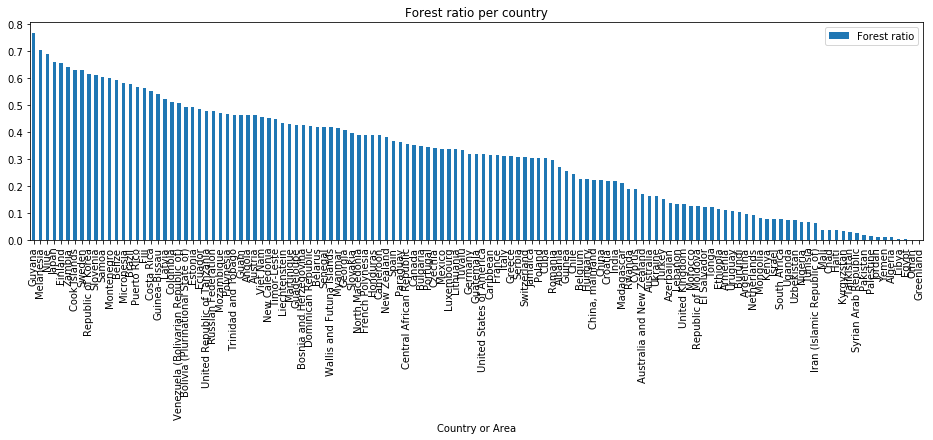

In [16]:
forest_land.sort_values(by=["Ratio"], ascending=False)\
           .loc[(forest_land["Year"] == 2017) & (~forest_land["Country or Area"].isin(areas_to_remove)), ["Country or Area", "Ratio"]]\
           .plot.bar(x="Country or Area", y="Ratio", title="Forest ratio per country", label="Forest ratio", figsize=(16,4))

### Discover trends in number of bees

In [17]:
# saving a dataframe with just countries 
beehives_countries = beehives.loc[~beehives["Country or Area"].isin(areas_to_remove)]

In [18]:
# --- same as anel --- find the countries that have lost more than 100000 beehives from 1992 to 2017
# BE CAREFUL, anel dataset has different name for "Country or Area"
count_decreasingNumber = 0
big_decrease = []
for country in countries:
    try:
        sm1 = float(beehives_countries.loc[(beehives_countries['Country or Area'] == country) & (beehives_countries['Year'] == 1992)]['Value'])
        sm2 = float(beehives_countries.loc[(beehives_countries['Country or Area'] == country) & (beehives_countries['Year'] == 2017)]['Value'])
        if sm2/sm1 < 1:
            count_decreasingNumber += 1
        if sm2-sm1<-100000:
            print(country)
            print("Ratio 2017/1992: %s" % (sm2/sm1))
            print("Number of Beehives in 1992: %s" % sm1)
            print("Number of Beehives in 2017: %s" % sm2)
            print("------------------")
            big_decrease.append(country)
    except:
        continue
print("The number of beehives in the period from 1992-2017 decreased in %s of %s countries." % (count_decreasingNumber, len(countries)))

Austria
Ratio 2017/1992: 0.7311490608676937
Number of Beehives in 1992: 483212.0
Number of Beehives in 2017: 353300.0
------------------
Egypt
Ratio 2017/1992: 0.6202381625441696
Number of Beehives in 1992: 1415000.0
Number of Beehives in 2017: 877637.0
------------------
France
Ratio 2017/1992: 0.7404548374275484
Number of Beehives in 1992: 1061742.0
Number of Beehives in 2017: 786172.0
------------------
Germany
Ratio 2017/1992: 0.5836318493150685
Number of Beehives in 1992: 1168000.0
Number of Beehives in 2017: 681682.0
------------------
Italy
Ratio 2017/1992: 0.32595129375951293
Number of Beehives in 1992: 1314000.0
Number of Beehives in 2017: 428300.0
------------------
Kenya
Ratio 2017/1992: 0.73774
Number of Beehives in 1992: 2200000.0
Number of Beehives in 2017: 1623028.0
------------------
Mexico
Ratio 2017/1992: 0.8795744769687865
Number of Beehives in 1992: 2107618.0
Number of Beehives in 2017: 1853807.0
------------------
Morocco
Ratio 2017/1992: 0.6720601092896175
Number 

In [19]:
forest_land.sort_values(by=["Ratio"], ascending=False)\
           .loc[(forest_land["Year"] == 2017) & (forest_land["Country or Area"].isin(big_decrease)), ["Country or Area","Ratio"]]\

,Country or Area,Ratio
10800,Russian Federation,0.476568
892,Austria,0.461689
8100,Mexico,0.335256
5002,Germany,0.319453
13640,United States of America,0.315969
4670,France,0.313520
6290,Italy,0.312093
12588,Switzerland,0.305543
8458,Morocco,0.125764
6566,Kenya,0.077299


It seems that for countries where the number of beehives is decreasing the forest ratio is quite low. Interesting!

Let's see what happens in countries where the number is increasing.

In [20]:
# also anels code -- be careful as before when merging!!!

count_increasingNumber = 0
big_increase = []
for country in countries:
    try:
        sm1 = int(beehives_countries.loc[(beehives_countries['Country or Area'] == country) & (beehives_countries['Year'] == 1992)]['Value'])
        sm2 = int(beehives_countries.loc[(beehives_countries['Country or Area'] == country) & (beehives_countries['Year'] == 2017)]['Value'])
        if sm2/sm1 > 1:
            count_increasingNumber += 1
        if sm2-sm1>500000:
            print(country)  
            big_increase.append(country)
    except:
        continue
print("The number of beehives in the period from 1992-2017 increased in %s of %s countries." % (count_increasingNumber, len(countries)))

Argentina
Australia and New Zealand
China
China, mainland
India
Iran (Islamic Republic of)
New Zealand
Republic of Korea
Spain
Tunisia
Turkey
United Republic of Tanzania
The number of beehives in the period from 1992-2017 increased in 77 of 165 countries.


In [21]:
forest_land.sort_values(by=["Ratio"], ascending=False)\
           .loc[(forest_land["Year"] == 2017) & (forest_land["Country or Area"].isin(big_increase)), ["Country or Area","Ratio"]]\

,Country or Area,Ratio
10580,Republic of Korea,0.614667
13584,United Republic of Tanzania,0.478370
9018,New Zealand,0.379231
12308,Spain,0.365385
2780,"China, mainland",0.221068
2724,China,0.220214
5898,India,0.216103
836,Australia and New Zealand,0.169210
13144,Turkey,0.151777
560,Argentina,0.095376


This result doesn't confirm the fact highlighted before, but could it still be some correlation? Let's check Spearman and Pearson correlations.

### Spearman and Pearson correlation

Joining datasets for calculating correlations

In [22]:
joined = beehives_countries.set_index(["Country or Area","Year"]).join(forest_land.set_index(["Country or Area","Year"]), lsuffix='_beehives', rsuffix='_forest')
joined = joined.reset_index()

##### Pearson correlation

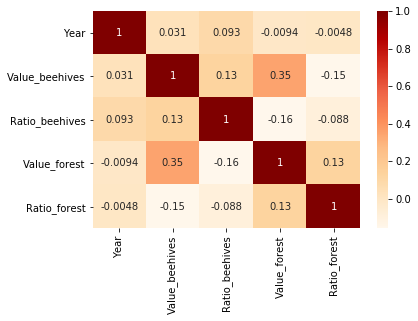

In [23]:
pearson_corr = joined.corr("pearson")
sns.heatmap(pearson_corr, fmt='.2g',annot=True, cmap="OrRd")

##### Spearman correlation

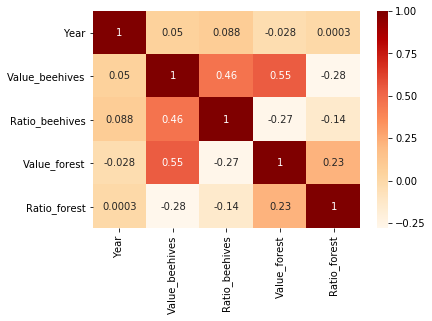

In [24]:
spearman_corr = joined.corr("spearman")
sns.heatmap(spearman_corr, fmt='.2g',annot=True, cmap="OrRd")

##### Correlation per year

In [25]:
def show_spearman(year=2017, method=["pearson", "spearman"]):
    corr_mat = joined.loc[joined["Year"] == year].loc[:,joined.columns != "Year"].corr(method)
    sns.heatmap(corr_mat, fmt='.2g',annot=True, cmap="OrRd")
    
interact(show_spearman, year=widgets.IntSlider(min=1990, max=2017, step=1));

interactive(children=(IntSlider(value=1990, description='year', max=2017, min=1990), Dropdown(description='met…

We can see that we have some correlation (both for Pearson and Spearman) between forests surface area in a country and number of beehives in that country. 

For Spearman we also have a weaker correlation between ratio of forests and number of beehives.

The forest concentration is probably not the only factor that influence the number of beehives, but it could have an impact on it.